In [1]:
#os, numpy and pandas for basic operations and data manipulation
import os
import numpy as np
import pandas as pd
import random
from itertools import cycle

#pillow will be used for image manipulation
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

#xml required to parse annotation files
import xml.etree.ElementTree as ET

#train_test_split used for creating a stratified split of training and test data
from sklearn.model_selection import train_test_split

#models will be built using Keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models

#keras tuner used for model tuning
import keras_tuner
from keras_tuner.engine.hyperparameters import HyperParameter
from keras_tuner import BayesianOptimization

#sklearn metrics will be used for examining results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [2]:
#check that TensorFlow is able to detect the GPU
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("GPU Ready and available")
else:
    print("panic")

GPU Ready and available


In [3]:
#set directory for image and annotation files
img_dir = ".\images"
anno_dir = r".\annotations"

In [4]:
def ordinal_encode(df_in):
    """
    Function to ordinally encode classes from strings
    df_in - dataframe of data for encoding
    df_out - returned dataframe with encoding
    """
    df_out=df_in.replace({
        "without_mask":0,
        "mask_weared_incorrect":1,
        "with_mask":2        
    })
    return df_out

In [5]:
def image_cropping(df_in):
    """
    short function that takes a dataframe of training or test samples and crops them
    df_in: dataframe of image names and bounding boxes
    df_out: dataframe with new image names appended
    location: storage location for cropped images
    """
     
    #loop through all bounding boxes
    for i in df_in.index:
        #locate file name
        f=df_in.loc[i,"file"]
        
        #locate class
        cls=df_in.loc[i,"target"]
        
        #load base image for file name
        active_img=Image.open(f".\images\{f}.png")
    
        #set boundry box corners
        xmin=df_in.loc[i,"xmin"]
        ymin=df_in.loc[i,"ymin"]
        xmax=df_in.loc[i,"xmax"]
        ymax=df_in.loc[i,"ymax"]
        
        #set the area to be cropped from the base image
        crop_area = (xmin, ymin, xmax, ymax)
        
        #create the new cropped image
        cropped_img = active_img.crop(crop_area)
        
        #resize the image
        resized_img = cropped_img.resize((36,36), Image.ANTIALIAS)
        
        #ensure the storage directory exists
        if not os.path.exists("data"):
            os.mkdir("data")
        
        #append the specific image name including target class
        df_in.loc[i,"img"]=f"{i}_{cls}.png"
        
        #save the new image
        resized_img.save(f"data\{i}_{cls}.png")
    
    df_out=df_in.copy()
    
    return df_out

In [6]:
def over_sampler(df_in):
    """
    function for random augmentation of images to balance each class
    df_in - dataframe of images by class
    """
    total_count=0
    
    #create a random rotation function
    def random_rotation(img):
        #50% chance of being applied
        if random.random() > 0.5:
            rotation=random.uniform(-15,15)
            rotated_img=img.rotate(rotation)
        else:
            rotated_img=img
        return rotated_img
    
    #create a random flip function
    def random_flip(img):
        if random.random() > 0.5:
            flipped_img=img.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            flipped_img=img
        return flipped_img
    
    #create a random blur function
    def random_gaussian_blur(img):
        if random.random() > 0.5:
            radius=random.uniform(2,3)
            blurred_image=img.filter(ImageFilter.GaussianBlur(radius=radius))
        else:
            blurred_image=img
        return blurred_image
    
    #create a random brightness adjustment
    def random_brightness(img):
        if random.random() > 0.5:
            brightness=random.uniform(0.45,0.55)
            enhancer=ImageEnhance.Brightness(img)
            bright_img=enhancer.enhance(brightness)
        else:
            bright_img=img
        return bright_img
            
    
    #count each class
    target_counts=pd.DataFrame()
    
    #loop through each class
    for i in df_in["target"].unique():
        #calculate the length of the active class
        count=len(df_in[df_in["target"]==i])
        
        #calculate the total for all classes
        total_count=total_count+count
        
        #append each class and number per class
        target_counts=target_counts.append({
            "target":int(i),
            "count":count
        },ignore_index=True)
       
    #determine largest class
    major_class=target_counts["count"].max()
    
    #loop through each class
    for i in target_counts["target"].unique():
        
        #set an active filtered dataframe
        working_df=df_in[df_in["target"]==i]
        
        #set the current length of the class
        c = len(working_df)
        
        #create a list of available images
        img_list=working_df[working_df["target"]==i]["img"].tolist()
        
        #loop through until the current class is the same length as the major class
        while c <= major_class:
            #increase the total count for the unique file name
            total_count+=1
            
            #pick a random image from list
            img = random.choice(img_list)
            
            #open random image from list
            img = Image.open(f".\data\{img}")
            
            #apply random rotation with built in random chance of being applied
            img = random_rotation(img)
            
            #apply random flip with built in random chance of being applied
            img = random_flip(img)
            
            #apply random blur with built in random chance of being applied
            img = random_gaussian_blur(img)
            
            #apply random brightness with built in random chance of being applied
            img = random_brightness(img)
        
            #create a new filename for the new image
            new_f_name=f"{total_count}_{int(i)}.png"
        
            #save the image back to the data directory
            img.save(f".\data\{new_f_name}")
            
            #append the new image to the df
            df_in=df_in.append({
                "target":i,
                "img":new_f_name
            },ignore_index=True)

            #increase the length of the class
            c+=1

    return df_in

In [7]:
def create_X_y(df_in):
    """
    function to create the input X array and target y vector for the model
    df_in - input dataframe of image names and target classes
    X_out - output array of size (none, 36, 36, 3)
    y_out - output vector of size (none, 1)
    """
    #create the empty matrix
    X_out = []
    
    #loop through all images listed in the input dataframe
    for i in df_in.index:
        
        #set the file name for os
        f=df_in.loc[i,"img"]
        
        #read the image in
        img = Image.open(f".\data\{f}")
        
        #convert to RGB for the colour dim
        rgb_img = img.convert("RGB")
        
        #convert image to numpy array of integers
        img_arr = np.asarray(rgb_img,dtype="int")
        
        #append to the master array
        X_out.append(img_arr)
    
    #convert master array to numpy array
    X_out = np.asarray(X_out)
    
    #normalise for colour dimension
    X_out = X_out / 255
    
    #create vector of targets
    y_out = np.asarray(df_in[["target"]])
    
    return X_out, y_out

In [8]:
def build_model(hp):
    """
    Function to create tunable convnet [hp=hyper-parameters]
    """
    
    #initialise a sequential network
    model = keras.Sequential()
    
    #add the first convoultional layer with the input shape
    model.add(layers.Conv2D(filters=hp.Int(name="conv2d_filter_1",min_value=16, max_value=1024, step=8, default=512),
                           kernel_size=hp.Choice(name="conv2d_kernel_1", values = [2,4]),
                           activation="relu",
                           input_shape=(36,36,3)
                           ))
    
    #first max pooling layer
    model.add(layers.MaxPooling2D((2,2)))
    
    #add the second convolutional layer
    model.add(layers.Conv2D(filters=hp.Int(name="conv2d_filter_2",min_value=16, max_value=1024, step=8, default=512),
                           kernel_size=hp.Choice(name="conv2d_kernel_2", values = [2,4]),
                           activation="relu"
                           ))
    
    #second max pooling layer
    model.add(layers.MaxPooling2D((2,2)))
    
    #first regularisation
    model.add(layers.Dropout(0.5))
    
    #third convolusional layer
    model.add(layers.Conv2D(filters=hp.Int(name="conv2d_filter_3",min_value=16, max_value=1024, step=8, default=512),
                           kernel_size=hp.Choice(name="conv2d_kernel_3", values = [2,4]),
                           activation="relu"
                           ))
    
    #third max pooling layer
    model.add(layers.MaxPooling2D((2,2)))    
    
    #second regularisation
    model.add(layers.Dropout(0.5))
    
    #flatten to vector
    model.add(layers.Flatten()),
    
    #first fully connected layer
    model.add(layers.Dense(units=hp.Int(name="dense_layer_1",min_value=128, max_value=1024, step=16, default=512),
                          activation="relu"))
    
    #second fully connected layer and output for 3 classes
    model.add(layers.Dense(units=3,
                           activation="softmax"))

    #build the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice(name="learning_rate", values=[1e-2, 1e-3, 1e-4])),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    
    return model

In [9]:
def grid_search(dir_name):
    """
    function for grid-searching the hyper-parameter space
    dir_name - directory name for grid search history storage
    search_res - the resulting tuner object
    """
    search_res = BayesianOptimization(build_model,
                                      objective=keras_tuner.Objective("val_accuracy",
                                                                direction = "max"),
                                      max_trials=50,
                                      directory=dir_name,
                                      overwrite=False)
    return search_res

In [10]:
def run_metrics(model_in, X_test, y_test):
    """
    function to create the classification report and confusion matrix
    model_in - a keras model
    X_test - test sample of input X's
    y_test - test sampel of target y's
    """
    #predcit probabilties for test sample against each class
    y_prob = model_in.predict(X_test)
    
    #create a predictions list
    y_pred = []
    
    #loop through each set of predictions for an input X
    for i in y_prob:
        #identify the highest probability class as the prediction and append to the prediciton list
        y_pred.append(np.argmax(i))
        
    #create a series of labels for the report and confusion matrix    
    labels = ["No Mask", "Incorrect Mask", "Mask"]
    
    #create a classificaiton report and print out
    print("Classification Report:")
    print(classification_report(y_test,
                                y_pred,
                                target_names=labels))
    
    #create a confusion matrix and plot
    print("Confusion Matrix:")
    plt.figure(figsize=(6,6))
    ConfusionMatrixDisplay(confusion_matrix(y_test,
                                            y_pred),
                           display_labels=labels).plot()

In [11]:
def run_roc_curve(model_in, X_test, y_test, title):
    """
    function to create an ROC curve and calculate AUC for each class
    model_in - a keras model
    X_test - test sample of input X's
    y_test - test sampel of target y's
    title - chart title
    """
    #predcit probabilties for test sample against each class
    y_prob = model_in.predict(X_test)
    
    #create a predictions list
    y_pred = []
    
    #loop through each set of predictions for an input X
    for i in y_prob:
        #identify the highest probability class as the prediction and append to the prediciton list
        y_pred.append(np.argmax(i))
        
    #create a label binarizer for the test sample
    lb = LabelBinarizer().fit(y_test)
    
    #transform the predictions to a binarized format
    y_score = lb.transform(y_pred)
    
    #transform the ground truth to a binarized format
    y_test = lb.transform(y_test)
    
    #create false positives, true positives and auc dictionaries for results storage    
    tpr = dict()
    fpr = dict()
    roc_auc = dict()
    
    #loop through all three classes
    for i in range(3):
        #append the true positive and false positive rates for the roc_curve
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
        #append the auc to roc_auc
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
    
    #set colors for each class
    colors = cycle([(0,0,1),(1,0,0),(0,1,0.5)])
    
    #create label strings for each class
    labels={0:"No Mask",
           1:"Incorrect Mask",
           2:"Mask"}
    
    #create the figure
    plt.figure(figsize=(8,8))
    
    #loop through each class assigning an associated color per loop
    for i, color in zip(range(3),colors):
        #plot false positive on x, true positive on y
        plt.plot(fpr[i],
                tpr[i],
                color=color,
                lw=2,
                label=f"ROC Curve for: {labels.get(i)} (AUC = {roc_auc[i]:.2f})",
                )
        
    #create a diagonal line
    plt.plot([0,1],[0,1],"k--",lw=2)
    
    #set the x limit
    plt.xlim([0,1])
    
    #set the y limit
    plt.ylim([0,1])
    
    #set the x label
    plt.xlabel("False Positive Rate [-]")
    
    #set the y label
    plt.ylabel("True Positive Rate [-]")
    
    #set the title as per the input
    plt.title(title)
    
    #set the legend in the corner of the chart that should be empty
    plt.legend(loc="lower right")
    plt.show()    

# Data Prep

In [12]:
#create the annotation dataframe
ANNO_DF = pd.DataFrame()

#loop through all files in the annotation directory
for file in os.listdir(anno_dir):
    
    #set the path to the annotation directory
    path = f"{anno_dir}\{file}"
    
    #read the annotation XML file in to a tree
    tree = ET.parse(path)
    
    #seperate the file name from the extension
    file_name=file.split(".")
    file_name=file_name[0]
    
    #loop through all elements in the tree
    for elem in tree.iter():
        #determine if size elements
        if 'size' in elem.tag:
            for attr in list(elem):
                #determine if width element and extract
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                #determine if height element and extract
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        #determine if a boundary box object
        if 'object' in elem.tag:
            for attr in list(elem):

                #determine if boundary box target and extract
                if 'name' in attr.tag:
                    name = attr.text                 
                     
                #determine if boundary box dims and extract each dimensnion
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            
                            #append all extracted info to annotation dataframe
                            ANNO_DF=ANNO_DF.append({
                                "file":file_name,
                                "target":name,
                                "width":width,
                                "height":height,
                                "xmin":xmin,
                                "ymin":ymin,
                                "xmax":xmax,
                                "ymax":ymax
                            },ignore_index=True)

In [13]:
#apply ordinal encoding to annotation dataframe
ANNO_DF=ordinal_encode(ANNO_DF)

In [14]:
#extract the areas of interest for each boundary box, crop and store as a new file
ANNO_DF=image_cropping(ANNO_DF)

In [15]:
#split the annotation dataframe into training and test splits with stratification on the target class for balance
master_train, master_test = train_test_split(ANNO_DF,
                                   train_size = 0.8,
                                   random_state=42,
                                   stratify=ANNO_DF[["target"]]
                                  )

In [16]:
#create the test input matrix and output vector and check their shape
X_test, y_test=create_X_y(master_test)
print(X_test.shape)
print(y_test.shape)

(815, 36, 36, 3)
(815, 1)


# Baseline Modelling

In [17]:
#create the training input matrix and output vector and check their shape
X_train_base, y_train_base=create_X_y(master_train)
print(X_train_base.shape)
print(y_train_base.shape)

(3257, 36, 36, 3)
(3257, 1)


In [18]:
#create the baseline model gridsearch
baseline_search=grid_search("baseline_modelling")

INFO:tensorflow:Reloading Oracle from existing project baseline_modelling\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from baseline_modelling\untitled_project\tuner0.json


In [19]:
#complete the gridsearch
baseline_search.search(X_train_base,
                       y_train_base,
                       epochs=50,
                       validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [20]:
#set the baseline model to be the best model from the gridsearch
baseline_model = baseline_search.get_best_models(num_models=1)[0]

In [21]:
#save the baseline model and print the summary
baseline_model.save("baseline_model.h5")
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 752)       9776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 752)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 720)       2166480   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 720)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 720)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 520)         1

Classification Report:
                precision    recall  f1-score   support

       No Mask       0.88      0.96      0.92       143
Incorrect Mask       0.65      0.60      0.63        25
          Mask       0.99      0.97      0.98       647

      accuracy                           0.96       815
     macro avg       0.84      0.84      0.84       815
  weighted avg       0.96      0.96      0.96       815

Confusion Matrix:


<Figure size 432x432 with 0 Axes>

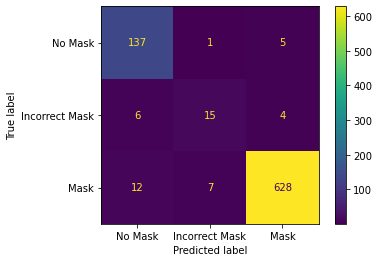

In [22]:
#run metrics on the baseline model
run_metrics(baseline_model,
            X_test,
            y_test)

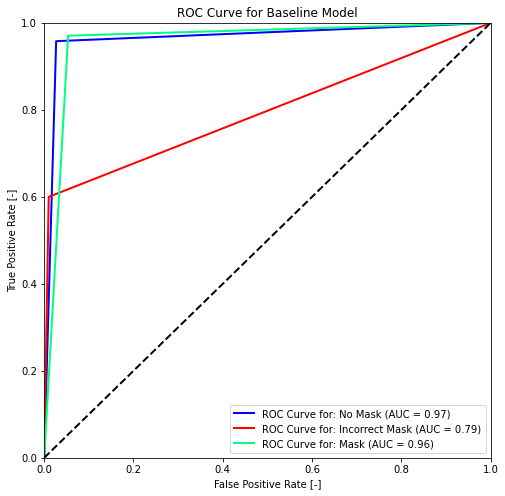

In [23]:
#create the ROC curve for the baseline model
run_roc_curve(baseline_model,
             X_test,
             y_test,
             title="ROC Curve for Baseline Model")

# Weighted Modelling

In [24]:
#create a dictionary to store the class weights
weights = {}

#loop through each class
for i in ANNO_DF["target"].unique():
    
    #filter the dataframe based on the current class
    w_df=ANNO_DF[ANNO_DF["target"]==i]
    
    #calculate the weight and append
    weights[i] = len(ANNO_DF)/(3*len(w_df))

In [25]:
#create the weighted model gridsearch
weighted_search=grid_search("weighted_modelling")

INFO:tensorflow:Reloading Oracle from existing project weighted_modelling\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from weighted_modelling\untitled_project\tuner0.json


In [26]:
#complete the weighted model gridsearch
weighted_search.search(X_train_base,
                      y_train_base,
                      epochs=50,
                      validation_split=0.2,
                      class_weight=weights)

INFO:tensorflow:Oracle triggered exit


In [27]:
#set the weighted model to be the best model from the gridsearch
weighted_model = weighted_search.get_best_models(num_models=1)[0]

In [28]:
#save the weighted model and print the summary
weighted_model.save("weighted_model.h5")
weighted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 720)       9360      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 720)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 1024)      11797504  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 1024)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 632)         2

Classification Report:
                precision    recall  f1-score   support

       No Mask       0.83      0.99      0.90       143
Incorrect Mask       0.56      0.60      0.58        25
          Mask       0.99      0.95      0.97       647

      accuracy                           0.94       815
     macro avg       0.79      0.84      0.82       815
  weighted avg       0.95      0.94      0.95       815

Confusion Matrix:


<Figure size 432x432 with 0 Axes>

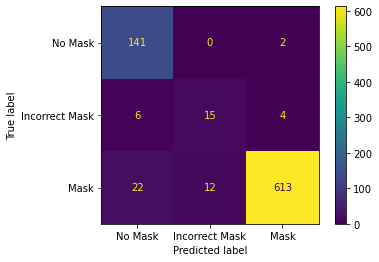

In [29]:
#run the metrics on the weighted model
run_metrics(weighted_model,
           X_test,
           y_test)

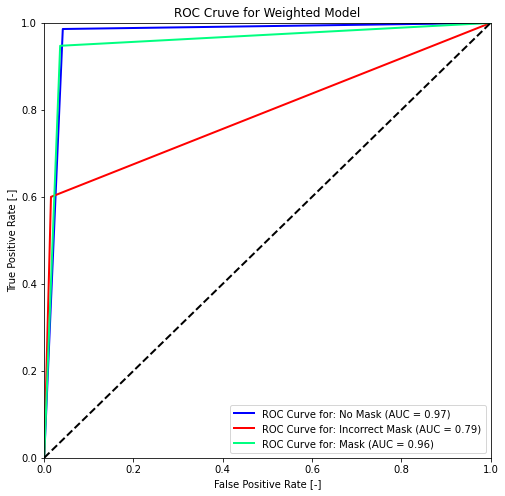

In [30]:
#run the ROC curve on the weighted model
run_roc_curve(weighted_model,
             X_test,
             y_test,
             "ROC Cruve for Weighted Model")

# Oversample Modelling

In [31]:
#create a new dataframe of expanded images to balance each class
master_train_over=over_sampler(master_train)

In [32]:
#create the test input matrix and output vector and check their shape for the oversampling
X_train_over, y_train_over=create_X_y(master_train_over)
print(X_train_over.shape)
print(y_train_over.shape)

(7758, 36, 36, 3)
(7758, 1)


In [33]:
#create the oversample gridsearch
oversample_search=grid_search("oversample_modelling")

INFO:tensorflow:Reloading Oracle from existing project oversample_modelling\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from oversample_modelling\untitled_project\tuner0.json


In [34]:
#complete the oversample gridsearch
oversample_search.search(X_train_over,
                         y_train_over,
                         epochs=50,
                         validation_split=0.2)

Trial 50 Complete [00h 01m 37s]
val_accuracy: 0.9948453903198242

Best val_accuracy So Far: 0.9948453903198242
Total elapsed time: 00h 23m 49s
INFO:tensorflow:Oracle triggered exit


In [35]:
#set the oversample model to be the best model from the gridsearch
oversample_model = oversample_search.get_best_models(num_models=1)[0]

In [36]:
#save the oversample model and print th summary
oversample_model.save("oversample_model.h5")
oversample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 1024)      13312     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 1024)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 480)       7864800   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 480)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 480)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 1024)        7

Classification Report:
                precision    recall  f1-score   support

       No Mask       0.93      0.96      0.94       143
Incorrect Mask       0.47      0.76      0.58        25
          Mask       0.99      0.96      0.97       647

      accuracy                           0.95       815
     macro avg       0.80      0.89      0.83       815
  weighted avg       0.96      0.95      0.96       815

Confusion Matrix:


<Figure size 432x432 with 0 Axes>

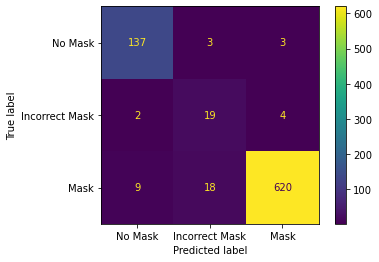

In [37]:
#run the metrics on the oversample model
run_metrics(oversample_model,
            X_test,
            y_test)

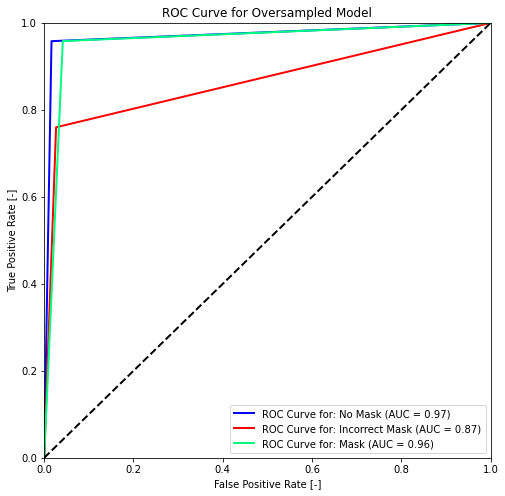

In [38]:
#create the ROC curve for the oversample model
run_roc_curve(oversample_model,
              X_test,
              y_test,
              title="ROC Curve for Oversampled Model")